<a href="https://colab.research.google.com/github/selveszero/530_final_project/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## To download data and train the model:

Run the following cells one by one.

In [0]:
# Run this cell to download all data

!mkdir data
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./data/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data/

!unzip -q ./data/captions_train-val2014.zip -d ./data/
!rm ./data/captions_train-val2014.zip
!unzip -q ./data/train2014.zip -d ./data/
!rm ./data/train2014.zip 
!unzip -q ./data/val2014.zip -d ./data/ 
!rm ./data/val2014.zip 

In [2]:
# necessary imports

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Make sure the following files are accessible before running the cells below:

*   build_vocab.py
*   data_loader.py
*   model.py
*   resize.py
*   train.py
*   sample.py


In [0]:
# build vocabulary into vocab.pkl in the data directory

!python build_vocab.py   


In [0]:
# resize all training images and store into resized2014 in the data directory

!python resize.py 

In [0]:
# resize all validation images and store into resizedval2014 in the data directory

!python resize.py --image_dir='data/val2014' --output_dir='data/resizedval2014'

In [6]:
# trains 5 epochs of the training data
# saving a pair of encoder-decoder models after running every 500 steps into model_path. 
# Can KeyboardInterrupt once a desired sized model is obtained.

!python train.py --save_step=500 --num_epochs=5 --model_path='saved_models'

Namespace(batch_size=128, caption_path='data/annotations/captions_train2014.json', crop_size=224, embed_size=256, hidden_size=512, image_dir='data/resized2014', learning_rate=0.001, log_step=100, model_path='saved_models', num_epochs=5, num_layers=1, num_workers=2, save_step=500, vocab_path='data/vocab.pkl')
loading annotations into memory...
Done (t=0.96s)
creating index...
index created!
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100% 553433881/553433881 [00:11<00:00, 49025380.45it/s]
Epoch [0/5], Step [0/3236], Loss: 9.2030, Perplexity: 9926.9320
Epoch [0/5], Step [100/3236], Loss: 3.9342, Perplexity: 51.1194
Epoch [0/5], Step [200/3236], Loss: 3.4303, Perplexity: 30.8853
Epoch [0/5], Step [300/3236], Loss: 3.2047, Perplexity: 24.6479
Epoch [0/5], Step [400/3236], Loss: 3.0816, Perplexity: 21.7941
Epoch [0/5], Step [500/3236], Loss: 2.9003, Perplexity: 18.1793
Epoch [0/5], Step [600/3236], Loss: 2.8665, 

## Saved models:

After running the above codes, the models will be saved in the 'saved_models' directory. 

## To generate caption for a given image:

1.   Upload the image to the current directory.
2.   Uncomment the next cell and change the image path.
3.   Change the encoder_path and decoder_path to choose which pair of models to use.





In [7]:

# !python sample.py --image='red_house.png' --encoder_path='saved_models/encoder-1-500.ckpt' --decoder_path='saved_models/decoder-1-500.ckpt' 


<start> a group of people standing on a beach with a kite . <end>


##To compute BLEU scores on the validation set:

Run the following 2 cells.



In [0]:
# change encoder_path and decoder_path to experiment with different pairs of models
encoder_path = 'saved_models/encoder-1-1000.ckpt'
decoder_path = 'saved_models/decoder-1-1000.ckpt'


''' Make sure if any of the following parameters are changed (not default) during training, 
they need to be changed down here too for evaluation. '''

embed_size = 256
hidden_size = 512
num_layers = 1


# paths not to be changed:
vocab_path = 'data/vocab.pkl'
imagedir = 'data/resizedval2014/'
caption_path = 'data/annotations/captions_val2014.json'


import torch
import matplotlib.pyplot as plt
import numpy as np 
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
import importlib
import model
importlib.reload(model)
from model import EncoderCNN, DecoderRNN
from PIL import Image

from pycocotools.coco import COCO

from nltk.translate.bleu_score import corpus_bleu

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    
    image = transform(image).unsqueeze(0)
    return image
  
def Compute_bleu():
  sum_bleu1 = 0
  sum_bleu2 = 0
  sum_bleu3 = 0
  sum_bleu4 = 0
  
  coco = COCO(caption_path)
  ann_ids = list(coco.anns.keys())
  print(len(ann_ids))
  counter = 0
  
  
  image2ann_ids = {}
  
  for ann_id in ann_ids:
    img_id = coco.anns[ann_id]['image_id']
    if img_id in image2ann_ids:
      image2ann_ids[img_id].append(ann_id)
    else:
      image2ann_ids[img_id] = [ann_id]
    
    
    
  for img_id in image2ann_ids:
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    # Prepare an image
#     img_id = coco.anns[ann_id]['image_id']
    path = coco.loadImgs(img_id)[0]['file_name']
    image_path = imagedir + path
    
    image = load_image(image_path, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    
    # get reference captions
    references = []
#     cap = coco.anns[ann_id]['caption']
    for ann_id in image2ann_ids[img_id]:
      cap = coco.anns[ann_id]['caption']
      tokens = nltk.tokenize.word_tokenize(str(cap).lower())
      caption = []
      caption.append('<start>')
      caption.extend([token for token in tokens])
      caption.append('<end>')
      references.append(caption)
    
    
    hypotheses = [sentence] * len(references)
    
    #bleu1
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    sum_bleu1 += bleu1
    #bleu2
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    sum_bleu2 += bleu2
    #bleu3
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    sum_bleu3 += bleu3
    #bleu4
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    sum_bleu4 += bleu4

    counter += 1
  
    if counter % 10 == 0 or len(references)!=5:
      print('After', counter, 'validation instances:')
      print('net BLEU-1 score:', sum_bleu1/counter)
      print('net BLEU-1 score:', sum_bleu2/counter)
      print('net BLEU-3 score:', sum_bleu3/counter)
      print('net BLEU-4 score:', sum_bleu4/counter)
      print('For validation instance number', counter, ':')
      print('Image path:', image_path)
      print('Gold captions:')
      for i, caption in enumerate(references):
        print(' '.join(caption))
      print('Generated caption:\n', sentence)
      print()
      
  print('final BLEU-1 score:', sum_bleu1/len(ann_ids))
  print('final BLEU-1 score:', sum_bleu2/len(ann_ids))
  print('final BLEU-3 score:', sum_bleu3/len(ann_ids))
  print('final BLEU-4 score:', sum_bleu4/len(ann_ids))
    



In [21]:
Compute_bleu()

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
202654
After 10 validation instances:
net BLEU-1 score: 0.36297869496151464
net BLEU-1 score: 0.361936347380486
net BLEU-3 score: 0.33230620429261337
net BLEU-4 score: 0.2883055463959657
For validation instance number 10 :
Image path: data/resizedval2014/COCO_val2014_000000331352.jpg
Gold captions:
<start> a small closed toilet in a cramped space . <end>
<start> a tan toilet and sink combination in a small room . <end>
<start> this is an advanced toilet with a sink and control panel . <end>
<start> a close-up picture of a toilet with a fountain . <end>
<start> off white toilet with a faucet and controls . <end>
Generated caption: <start> a bathroom with a toilet and a sink . <end>

After 20 validation instances:
net BLEU-1 score: 0.34506169443820844
net BLEU-1 score: 0.3374926346717552
net BLEU-3 score: 0.30416691879060787
net BLEU-4 score: 0.25996691254166476
For validation instance number 20 :
Image pa

KeyboardInterrupt: ignored

## To show an image in colab given the image path:

Paste the image path to replace the one in the cell below.

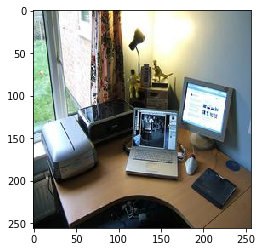

In [34]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('data/resizedval2014/COCO_val2014_000000079472.jpg')
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()